<a href="https://colab.research.google.com/github/srt3000/CE888/blob/main/CE888pilotstudySreejith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount the google drive which contains the unzipped dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fire Vs Non fire Image Classification using FLAME dataset
## Step 1: Building a Convnet from Scratch


Steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy


Check the number of images in each folder to verify if all the data is loaded correctly

The contents of the .zip are extracted to the base directory `base_dir = '/content/drive/MyDrive/FireVsNonfire'
`, which contains `train` and `test` subdirectories for the training and test datasets. Define each of the sub directories:

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
base_dir = '/content/drive/MyDrive/FireVsNonfire'
train_dir = os.path.join(base_dir, '/content/drive/MyDrive/FireVsNonfire/Training')
validation_dir = os.path.join(base_dir, '/content/drive/MyDrive/FireVsNonfire/Test')

# Directory with our training fire pictures
train_Fire_dir = os.path.join(train_dir, '/content/drive/MyDrive/FireVsNonfire/Training/Fire') 

# Directory with our training Nonfire pictures
train_Nonfire_dir = os.path.join(train_dir, '/content/drive/MyDrive/FireVsNonfire/Training/No_Fire')

# Directory with our validation fire pictures
validation_Fire_dir = os.path.join(validation_dir, '/content/drive/MyDrive/FireVsNonfire/Test/Fire')

# Directory with our validation Nonfire pictures
validation_Nonfire_dir = os.path.join(validation_dir, '/content/drive/MyDrive/FireVsNonfire/Test/No_Fire')

Let's find out the total number of fire and non fire images in the `train`and `test` directories:

In [ ]:
print('total training Fire images:', len(os.listdir(train_Fire_dir)))
print('total training Non Fire images:', len(os.listdir(train_Nonfire_dir)))
print('total validation Fire images:', len(os.listdir(validation_Fire_dir)))
print('total validation Non Fire images:', len(os.listdir(validation_Nonfire_dir)))

total training Fire images: 25018
total training Non Fire images: 14357
total validation Fire images: 5137
total validation Non Fire images: 3480


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over imagesFire
pic_index = 0

Now, display a batch of 8 Fire and 8 Non fire pictures. You can rerun the cell to see a fresh batch each time:

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_Fire_pix = [os.path.join(train_Fire_dir, fname) 
                for fname in train_Fire_fnames[pic_index-8:pic_index]]
next_Nonfire_pix = [os.path.join(train_NonFire_dir, fname) 
                for fname in train_NonFire_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_Fire_pix+next_Nonfire_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


NameError: ignored

<Figure size 1152x1152 with 0 Axes>

## Building a Small Convnet from Scratch to Get to 72% Accuracy

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2.)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)


# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(2048, activation='relu')(x)

# Create output layer with a single node and sigmoid activation

output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)


Let's summarize the model architecture:

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 70, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 33, 33, 128)       7385

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid.  We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training,classification accuracy is monitored.



In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['acc'])


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 - 239s - loss: 0.4581 - acc: 0.7680
Epoch 2/5
100/100 - 215s - loss: 0.2302 - acc: 0.9285
Epoch 3/5
100/100 - 207s - loss: 0.1757 - acc: 0.9430
Epoch 4/5
100/100 - 189s - loss: 0.1385 - acc: 0.9565
Epoch 5/5
100/100 - 170s - loss: 0.1005 - acc: 0.9670


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random Fire or non fire image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


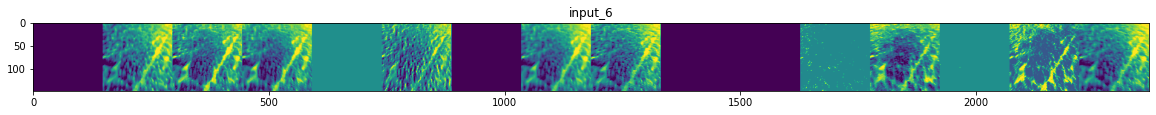

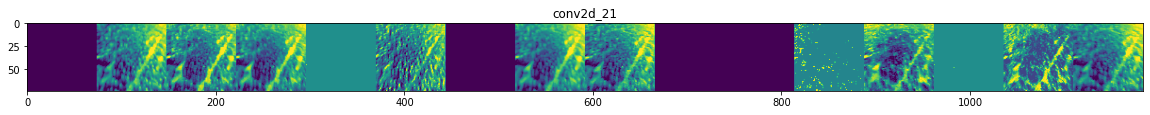

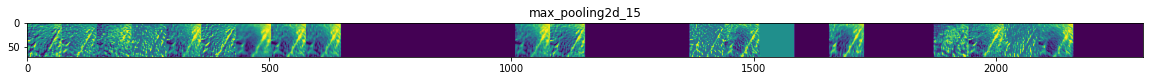

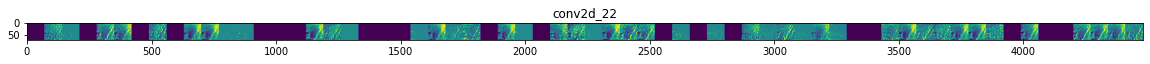

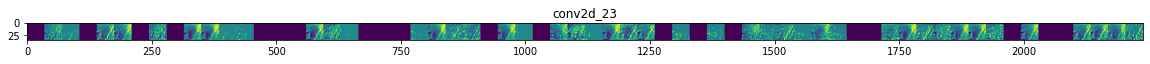

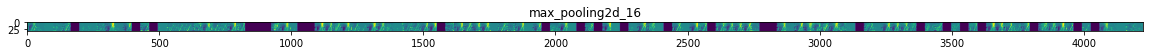

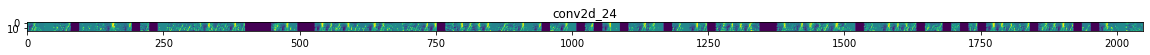

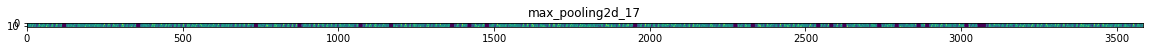

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a Fire or Nonfire from the training set.
Fire_img_files = [os.path.join(train_Fire_dir, f) for f in train_Fire_fnames]
Nonfire_img_files = [os.path.join(train_Nonfire_dir, f) for f in train_Nonfire_fnames]
img_path = random.choice(Fire_img_files + Nonfire_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

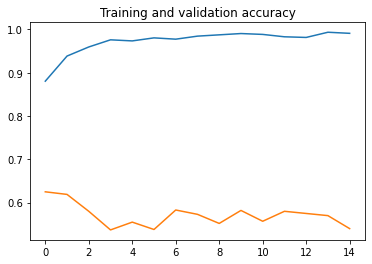

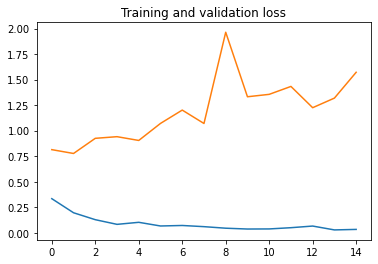

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

As you can see, we are **underfitting** The training accuracy (blue) gets closer to 100 percent but the validation accuracy is very less and the gap between them is very high. The training loss also can be seen as decreasing while the validation loss is increasing. Thus, we must make the model more complex and improve the data regularization. 